Lab 4: Experiments with Particle Filter

a) Write the code for the function sir() which implements the sample importance resampling

b) experiment with different number of particles and plot the error of the particle based approximation as a function of number of particles

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
def move (
      v, 
      w,
      x,
      y,
      theta,
      rng_r,
      rng_l,
      rng_t,
      tstep = 1,
      WHEELBASE = 1,
      SLIPPARAM = 10,
      ANGSTDDEV=0.0157,
      addNoise = True,
  ):
    '''
    Function: Implement noisy motion for a two wheeled robot. Noise happens due to wheel slippages
    Inputs: 
        2D pose (x,y, theta) at the beginning of time step
        velocity (linear and angular) 
    Parameters:
        Three random number generators: one for each wheel slippage and one for angular noise
        Wheele base width, power law parameter for slippage and std dev for angular noise
        addNoise: if True - adds motion noise using the random number generators
    Outputs:
        2D Pose (xn,yn, thetan) after applying the velocities and noise
    
    '''

    #calculate the desired velocities of the left and right wheel
    vl = v - 0.5*WHEELBASE*w
    vr = v + 0.5*WHEELBASE*w

    #sample left and right wheel slippage
    #from power law distribution
    #modeling probablity no slip: mostly no slip - occasional slip as as per 
    #pdf of power law pdf(x) a*x^(a-1) for x in [0,1] and a >= 1
    sr = rng_r.power(SLIPPARAM)
    sl = rng_l.power(SLIPPARAM)
    #model angular noise a gaussian
    nt = rng_t.normal(0,ANGSTDDEV)

    #incorporate the wheel slippage to get actual wheel linear velocities which will be smaller
    if addNoise :
        vla = vl*sl
        vra = vr*sr
    else:
        vla = vl
        vra = vr

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/WHEELBASE
    phi = math.copysign(1,vn)*wn * tstep

    #update the pose after the timestep
    if ( abs(wn)>0.0):  #has some rotation
      R = abs(vn)/wn
      xn = x - R*math.sin(theta) + R*math.sin(theta+phi)
      yn = y + R*math.cos(theta) - R*math.cos(theta+phi)
      thetan = theta + phi

    else:  #no rotation
      xn = x + (vla+vra)*0.5*tstep*math.cos(theta)
      yn = y + (vla+vra)*0.5*tstep*math.sin(theta)

    #now add the extra noise to angle
    if addNoise: 
        thetan = theta + nt 

    #keep theta within +- math.pi
    if ( thetan >= math.pi):
      thetan = thetan-2*math.pi
    if (thetan <= -math.pi):
      thetan = 2*math.pi -theta

    return xn,yn,thetan


def sMove (
      v,
      w,
      xEst,
      yEst,
      thetaEst,
      rngEst_r,
      rngEst_l,
      rngEst_t,
      tstep=1,
      WHEELBASE=1,
      velStdErr=0.1,
      angStdErr=math.pi*0.01,
  ) :
    
    '''
    Function: Sample motion model. Assume two wheeled robot 
    Inputs: 
        2D pose (x,y,theta)
        velocity (linear and angular)
    Parameters:
        random number generators for each wheel and angular velocity
        wheel base
        std deviations for the random noise
    Outputs:
        sampled 2D pose from the distribution
        
    Assumption: 
        wheel velocity noise is gaussian and independent
        Could be different noise model from actual
    '''
    vl = v - 0.5*WHEELBASE*w
    vr = v + 0.5*WHEELBASE*w

    #sample left and right wheel slippage
    #from power law distribution
    vra = rngEst_r.normal(vr,velStdErr)
    vla = rngEst_l.normal(vl,velStdErr)
    #model angular noise a gaussian
    nt = rngEst_t.normal(0,angStdErr)

    #regenerate the noise velocities
    vn = (vla+vra)/2
    wn = (vra-vla)/WHEELBASE
    phi = math.copysign(1,vn)*wn * tstep


    #update the pose after the timestep
#    if ( abs(vla-vra)>0.01*min(abs(vla),abs(vra))):  #has some rotation
    if ( abs(wn)>0):  #has some rotation
      R = abs(vn)/wn
      xn = xEst - R*math.sin(thetaEst) + R*math.sin(thetaEst+phi)
      yn = yEst + R*math.cos(thetaEst) - R*math.cos(thetaEst+phi)
      thetan = thetaEst + phi
    else:  #no rotation
      xn = xEst + (vla+vra)*0.5*tstep*math.cos(thetaEst)
      yn = yEst + (vla+vra)*0.5*tstep*math.sin(thetaEst)
      thetan = thetaEst

    #now add the extra noise to angle
    thetan = thetan + nt 

    #keep theta within +- math.pi
    if ( thetan >= math.pi):
      thetan = thetan-2*math.pi
    if (thetan <= -math.pi):
      thetan = 2*math.pi - thetan

    return xn, yn, thetan

#%%


#%%
def pltS (pp,tp,t):
    #scatter plot of the error in particle poses w.r.t true pose at time t
    plt.scatter(pp[:,t,0]-tp[t,0],pp[:,t,1]-tp[t,1],facecolor='red')
    plt.show()

#%%



In [ ]:
def proportional_sampling(particle, weights,r):
    # print(weights)
    #print(particle)
    total_sum = sum(weights)
    #print(total_sum)
    normalized_weights = [weight/total_sum for weight in weights]
    cum_sum = [normalized_weights[0]] # initializing
    for k in range(1, len(normalized_weights)):
        cum_sum.append(cum_sum[k-1] + normalized_weights[k])
    #print(cum_sum)
    for index, value in enumerate(cum_sum):
      #print(value)
      if r <=  value:
        #print(particle[index])
        return particle[index]

In [ ]:
# Your Code here
def sir (
    pp,
    plkl_a,
):
  ''' 
  Function: Sample Importance Resampling
  Inputs: 
      Vector of particles
      Vector of particle Log Likelihoods
  Outputs:
      Vector of resampled particles (new array)
      Vector for new log likelihoods for the resampled particles
  '''
  NPARTICLES = pp.shape[0]
  npp = np.zeros((NPARTICLES,NSTEPS,3)) #particles for pose estimate

  plkl_a = plkl_a - np.max(plkl_a)
  particleWt = np.exp(plkl_a)
  particleWt = particleWt/np.sum(particleWt)
  
  # your code here
  # table 4.4 probabilistic robotics
  r = np.random.random()*1.0/NPARTICLES
  c = particleWt[0]
  i = 0
  for m in range(NPARTICLES):
    U = r + (m-1)*(1/NPARTICLES)
    while U>c:
      i+=1
      c+=particleWt[i]
    npp[m] = pp[i]
    plkl_a[m] = plkl_a[i]

  # # for proptional sampling. Also gives the similar result.
  # for j in range(0,NPARTICLES):
  #   r = np.random.rand()
  #   idx = proportional_sampling(list(range(0,NPARTICLES)), particleWt,r)
  #   # print(idx)
  #   # print(j)
  #   npp[j] = pp[idx]
  #   plkl_a[j] = plkl_a[idx] 

  return npp, plkl_a

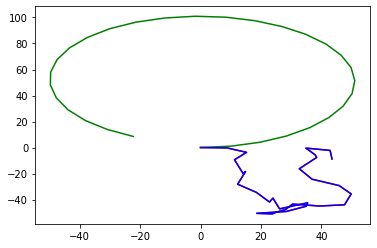

error when num particles is 1 is 2969.340890917158


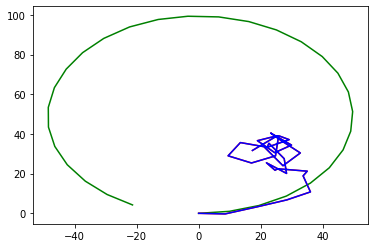

error when num particles is 2 is 1491.046779457526


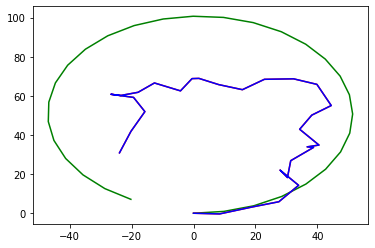

error when num particles is 3 is 831.5386844822041


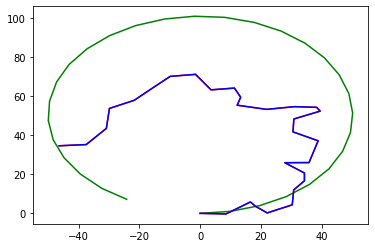

error when num particles is 4 is 1067.3424780910655


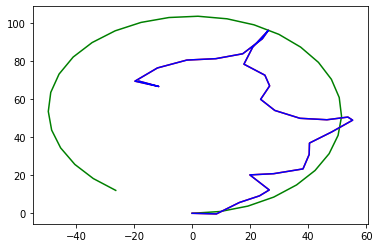

error when num particles is 5 is 1187.3242007834988


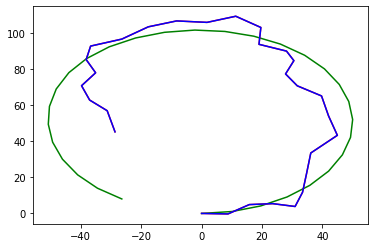

error when num particles is 6 is 728.5656810355274


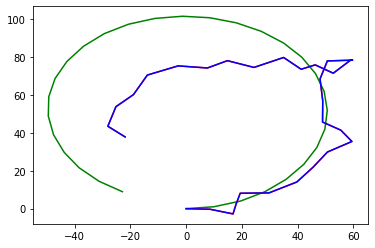

error when num particles is 7 is 1146.8790171494932


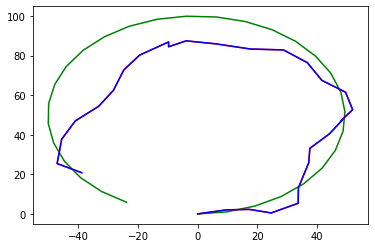

error when num particles is 8 is 722.8177686085586


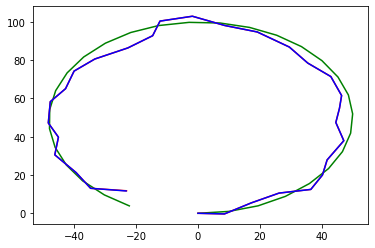

error when num particles is 9 is 147.744468041478


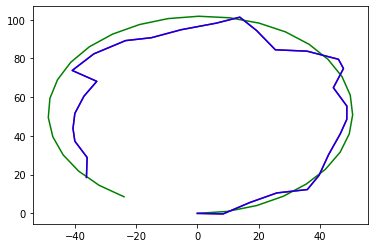

error when num particles is 10 is 284.8669702687218


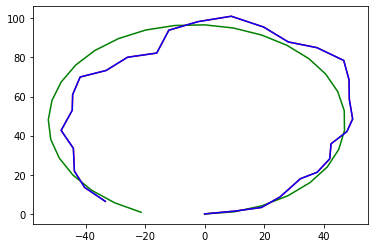

error when num particles is 11 is 386.9691731074691


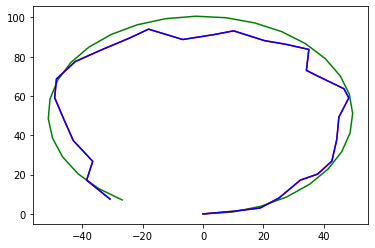

error when num particles is 12 is 263.270580054288


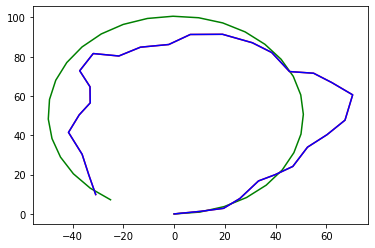

error when num particles is 13 is 413.5846248544688


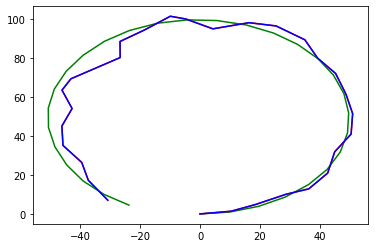

error when num particles is 14 is 146.0081417096931


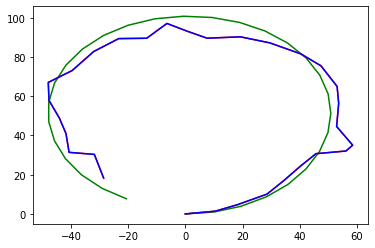

error when num particles is 15 is 330.7236726897325


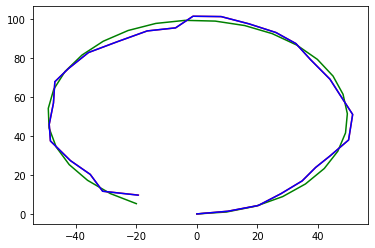

error when num particles is 16 is 79.39789762486697


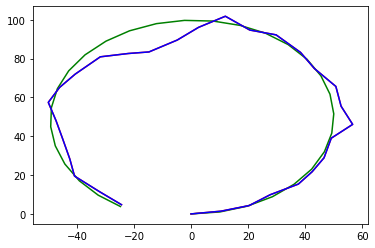

error when num particles is 17 is 128.51511637899952


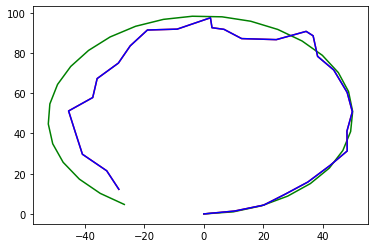

error when num particles is 18 is 301.90534366211756


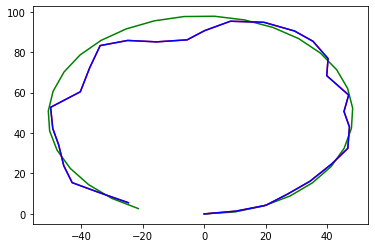

error when num particles is 19 is 139.34800269973005


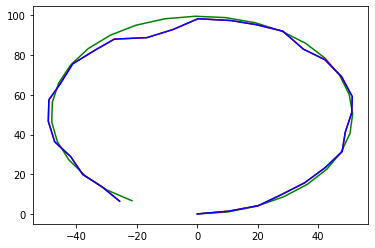

error when num particles is 20 is 51.88950575555993


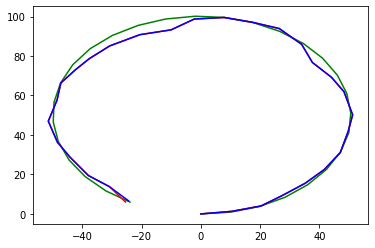

error when num particles is 21 is 52.18466337950402


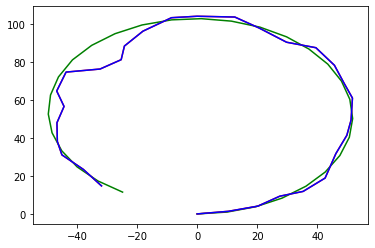

error when num particles is 22 is 109.27432752294054


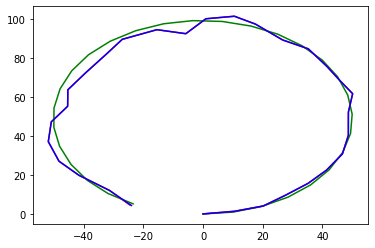

error when num particles is 23 is 90.18936093305096


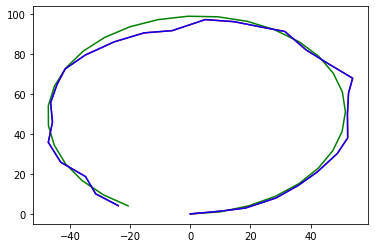

error when num particles is 24 is 89.92808241448391


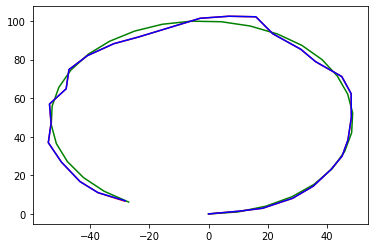

error when num particles is 25 is 59.152083467648566


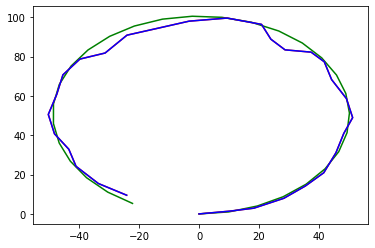

error when num particles is 26 is 146.038205791297


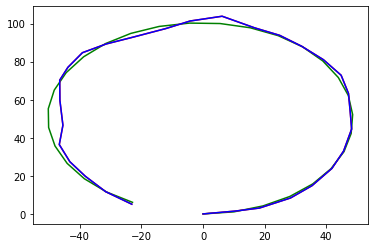

error when num particles is 27 is 50.19841920289863


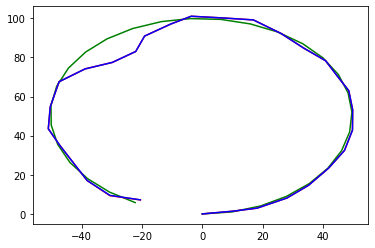

error when num particles is 28 is 69.212613268216


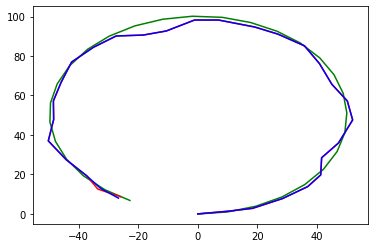

error when num particles is 29 is 77.04924885343951


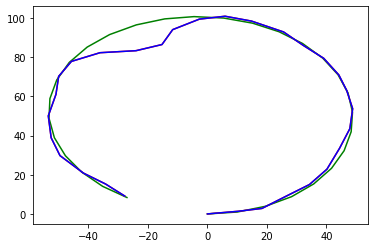

error when num particles is 30 is 71.59747739223903


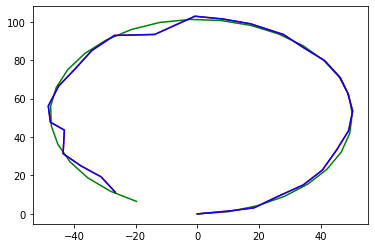

error when num particles is 31 is 81.70826760463902


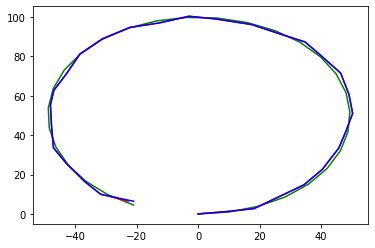

error when num particles is 32 is 36.68920330258899


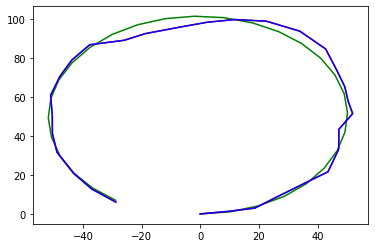

error when num particles is 33 is 93.82553976491697


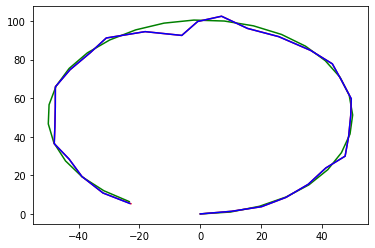

error when num particles is 34 is 49.16486512044557


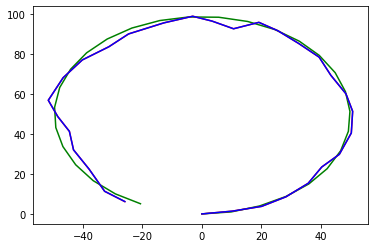

error when num particles is 35 is 123.11261053634978


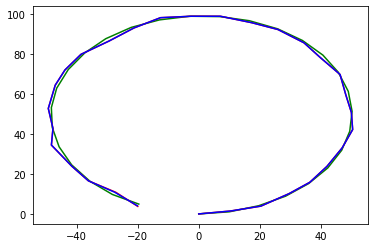

error when num particles is 36 is 31.671766798201766


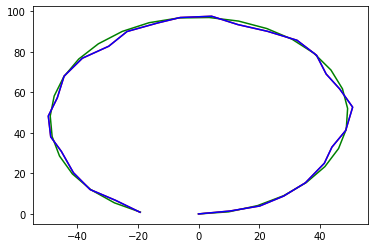

error when num particles is 37 is 36.47128937673193


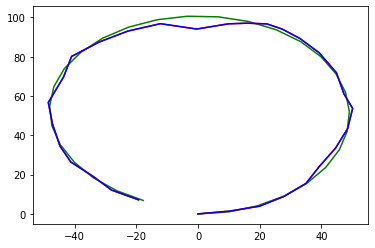

error when num particles is 38 is 107.44624392706228


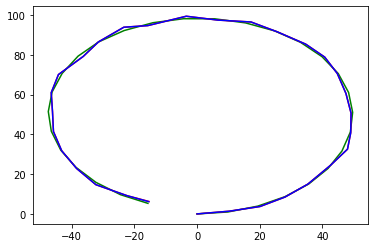

error when num particles is 39 is 31.19363972885983


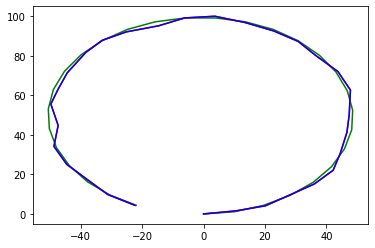

error when num particles is 40 is 36.537602529337086


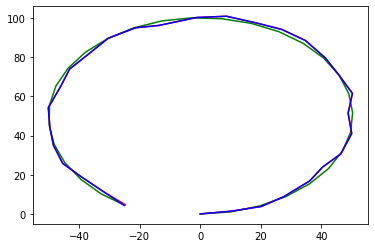

error when num particles is 41 is 34.06447839926255


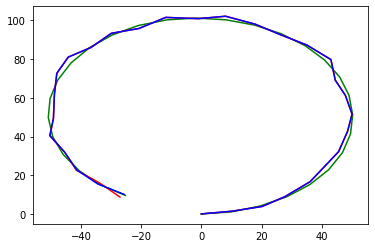

error when num particles is 42 is 39.72243157319371


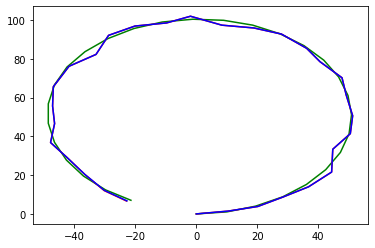

error when num particles is 43 is 39.978863642410914


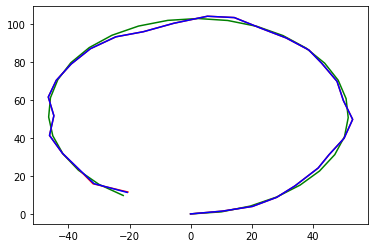

error when num particles is 44 is 41.28264327857623


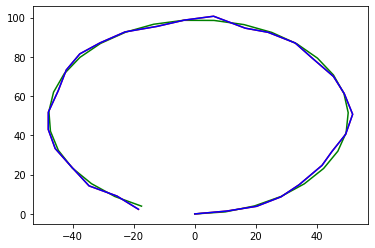

error when num particles is 45 is 34.25284588149368


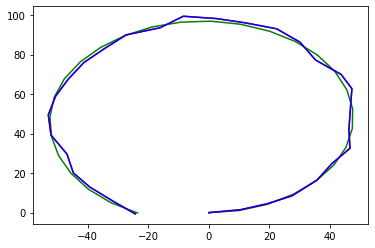

error when num particles is 46 is 41.67044124289301


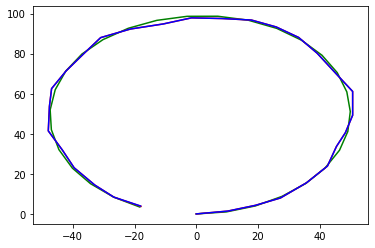

error when num particles is 47 is 34.026054463706785


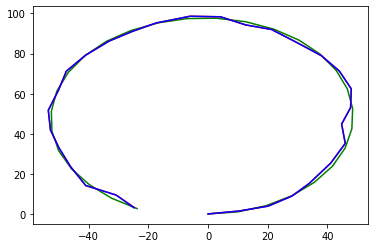

error when num particles is 48 is 35.50914623708256


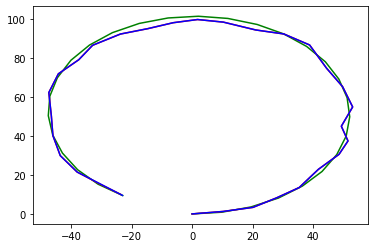

error when num particles is 49 is 56.64108110408654


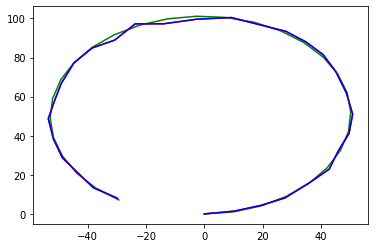

error when num particles is 50 is 34.43383653868921


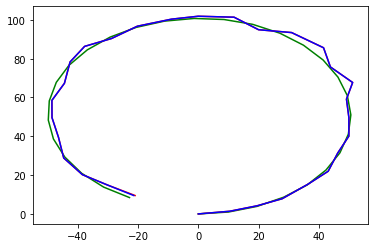

error when num particles is 51 is 57.61748263530613


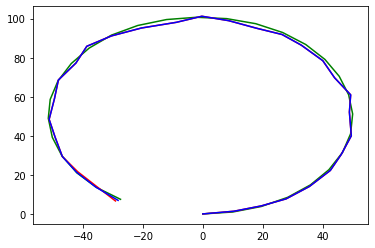

error when num particles is 52 is 32.64503500039329


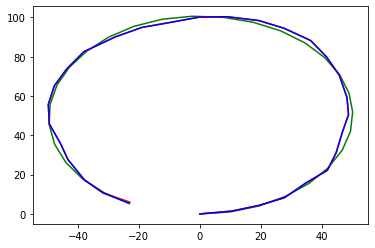

error when num particles is 53 is 42.52554778999384


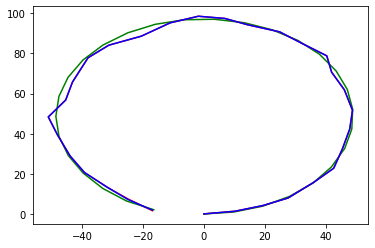

error when num particles is 54 is 51.484121991637295


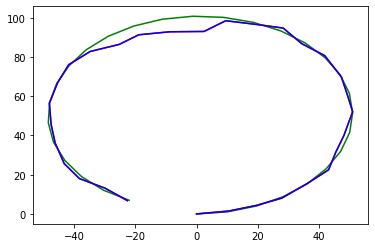

error when num particles is 55 is 54.15063200309227


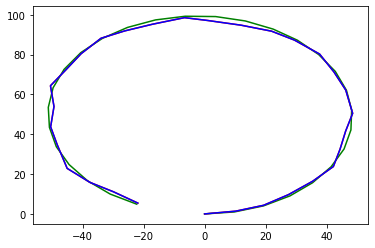

error when num particles is 56 is 34.127974576229676


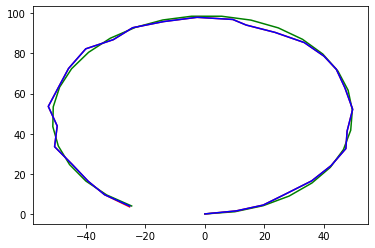

error when num particles is 57 is 38.138071630742466


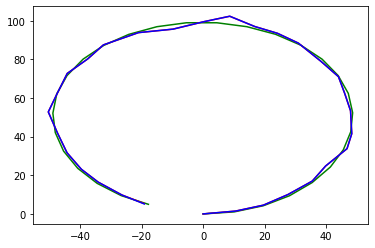

error when num particles is 58 is 45.541681518630035


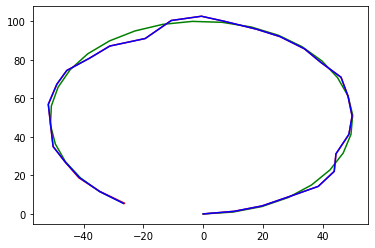

error when num particles is 59 is 43.0978677073745


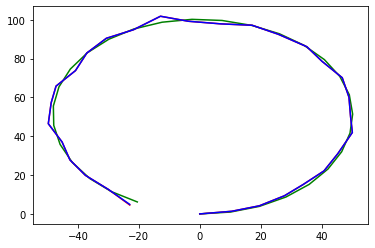

error when num particles is 60 is 39.149698040896006


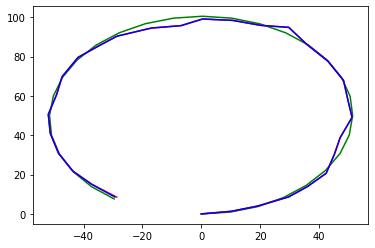

error when num particles is 61 is 40.96707873354321


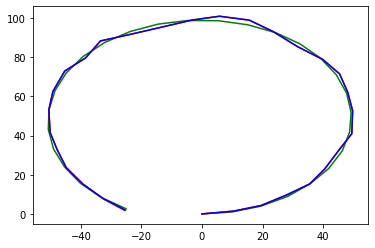

error when num particles is 62 is 32.343612444495804


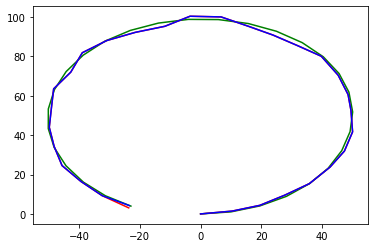

error when num particles is 63 is 32.40250999295119


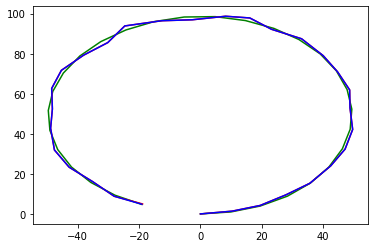

error when num particles is 64 is 35.520842046840144


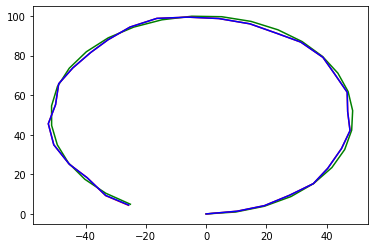

error when num particles is 65 is 31.12912347142387


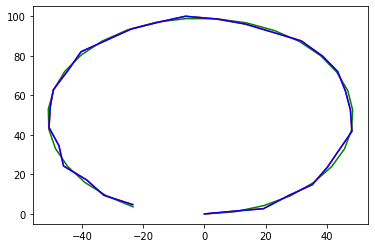

error when num particles is 66 is 31.08293210459057


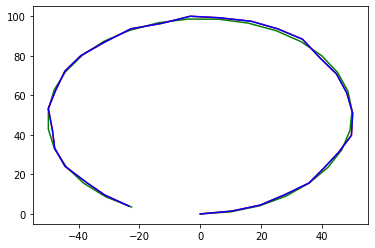

error when num particles is 67 is 27.110706178786078


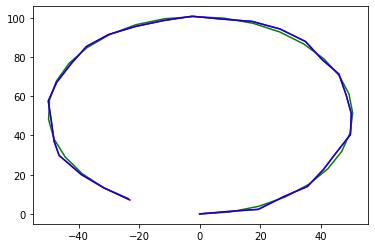

error when num particles is 68 is 28.290350841034403


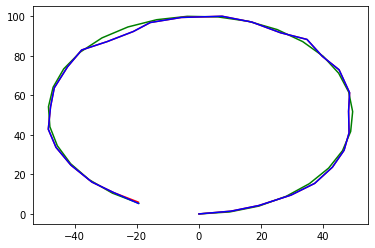

error when num particles is 69 is 35.908357533936865


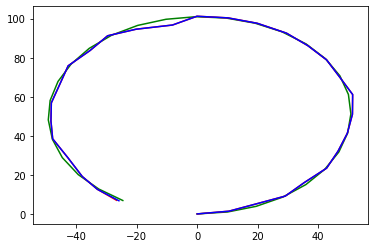

error when num particles is 70 is 32.39175690531153


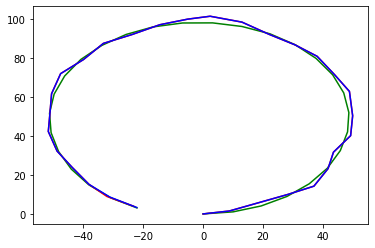

error when num particles is 71 is 39.77343140910628


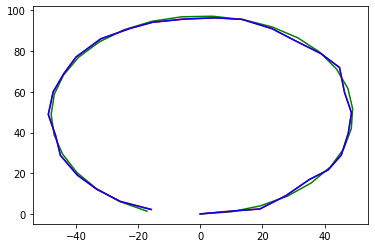

error when num particles is 72 is 36.125492335250264


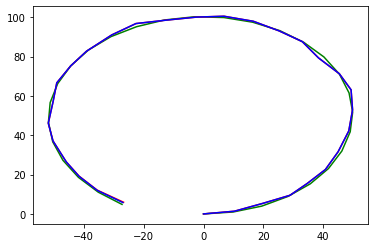

error when num particles is 73 is 25.599316774385272


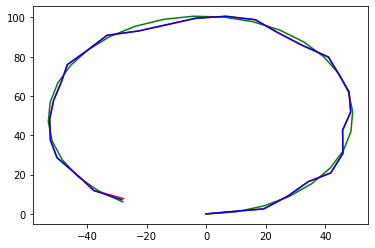

error when num particles is 74 is 40.32656734728944


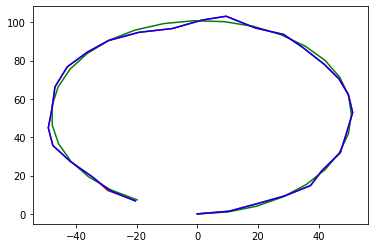

error when num particles is 75 is 37.48435062851581


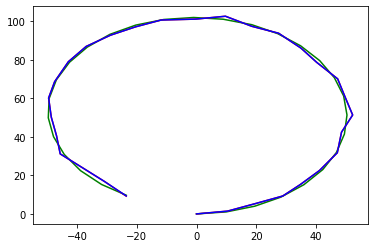

error when num particles is 76 is 29.533105300015762


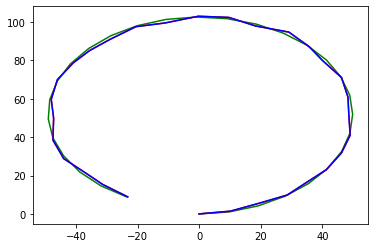

error when num particles is 77 is 31.17139504753589


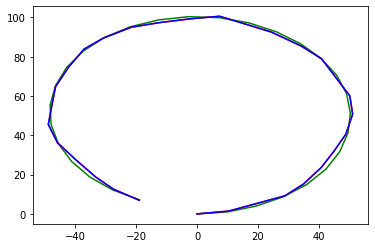

error when num particles is 78 is 29.633556717538813


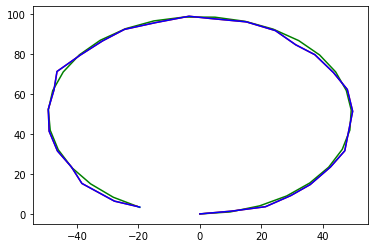

error when num particles is 79 is 30.22051499257989


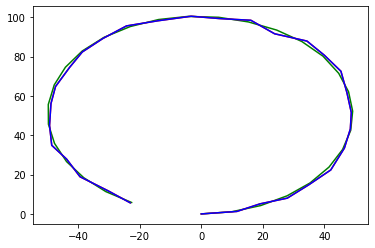

error when num particles is 80 is 30.353426342757515


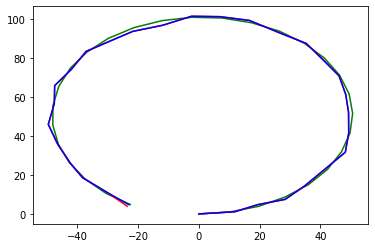

error when num particles is 81 is 30.88109277625656


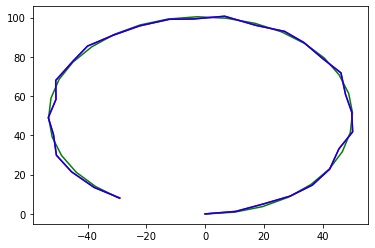

error when num particles is 82 is 27.806777864491398


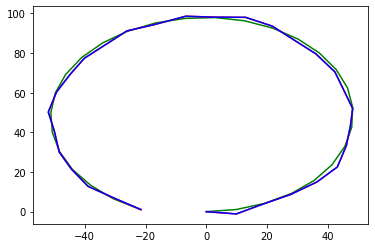

error when num particles is 83 is 28.78862193539626


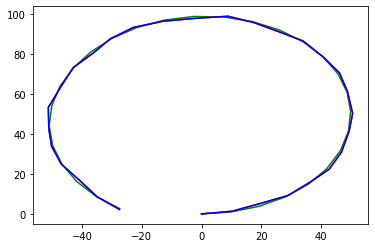

error when num particles is 84 is 23.5348621829482


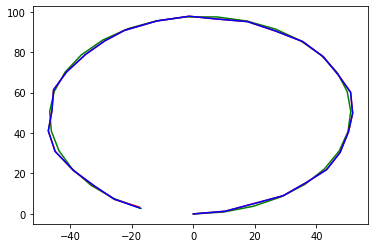

error when num particles is 85 is 25.231140358519774


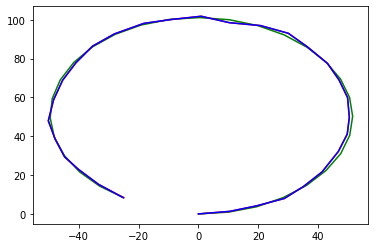

error when num particles is 86 is 26.395178075715705


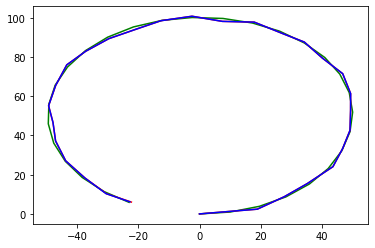

error when num particles is 87 is 27.25092392170513


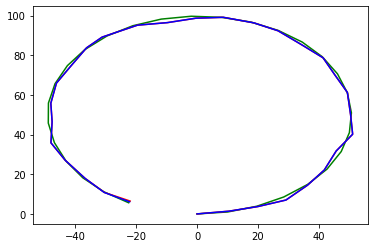

error when num particles is 88 is 29.31765448425668


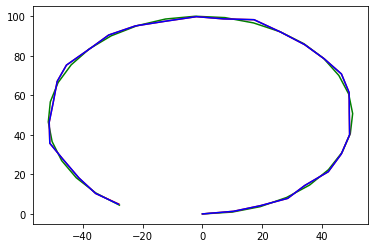

error when num particles is 89 is 24.32199362196124


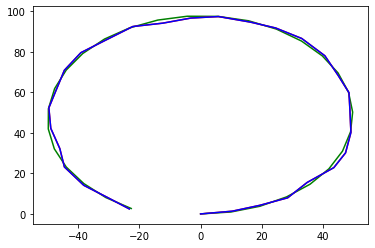

error when num particles is 90 is 26.744258724263428


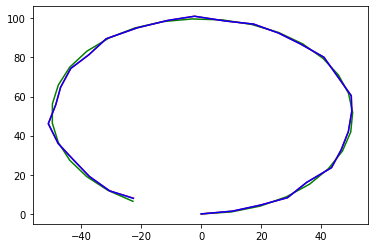

error when num particles is 91 is 28.743233301455543


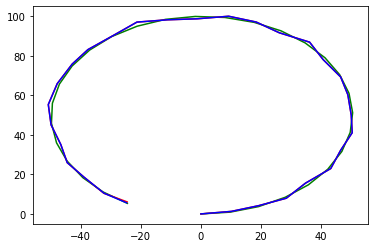

error when num particles is 92 is 27.70057155953277


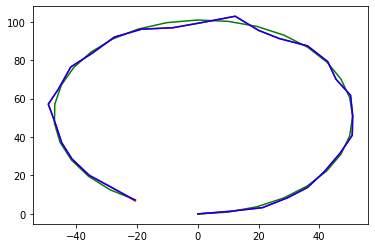

error when num particles is 93 is 37.015484985826006


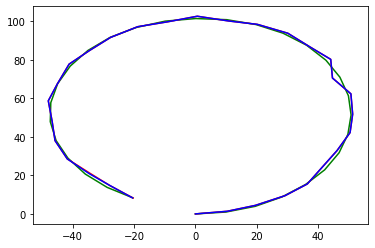

error when num particles is 94 is 27.70724934823548


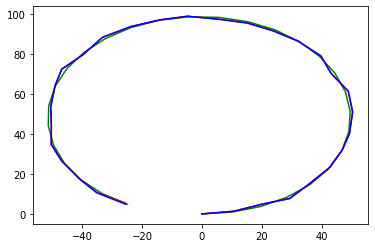

error when num particles is 95 is 26.679813324606705


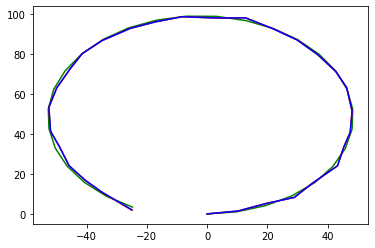

error when num particles is 96 is 30.54394218016629


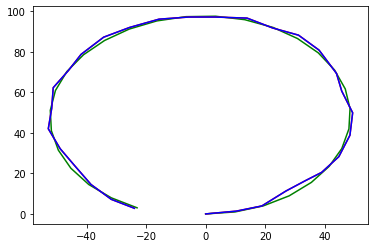

error when num particles is 97 is 42.92262401957319


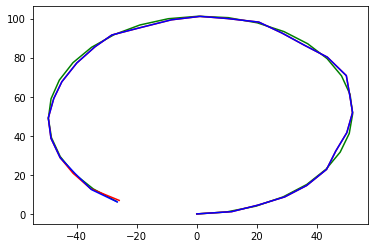

error when num particles is 98 is 25.564726832825976


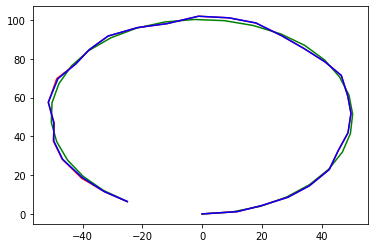

error when num particles is 99 is 32.07391840975188


In [ ]:
#check if particle filter based pose estimation is able to track true pose
error_combined = []
for NP in range(1,100):
  NSTEPS = 30                  #number of time steps for simulation
  #NP = 50

  tp = np.zeros((NSTEPS,3))     #True pose with time
  pp = np.zeros((NP,NSTEPS,3))  #Particles for pose
  ep = np.zeros((NP,NSTEPS,3))  #Particle pose errors
  mp = np.zeros((NSTEPS,3))     #measured pose

  plkl = np.zeros((NP,NSTEPS)) #log likelihood per step
  plkl_a = np.zeros(NP)        #accumulated likelihood per particle

  #initialize the random number generators
  rng_l = np.random.default_rng(1)     #for left wheel noise
  rng_r = np.random.default_rng(2)     #for right wheel noise
  rng_t = np.random.default_rng(3)     #for angle noise
  rngEst_l = np.random.default_rng(4)  #noise in left wheel in sample motion model
  rngEst_r = np.random.default_rng(5)  #noise of right wheel in sample motion model
  rngEst_t = np.random.default_rng(6)  #noise in angle for sample motion model
  rng_m = np.random.default_rng(7)     #for measurement noise of pose
  #%%      


  tp[0] = [0,0,0]

  for i in range(1,NSTEPS):
      #Velocity commands
      v = np.random.normal(10, 0.1)
      w = np.random.normal(0.2,0.01)
      
      #move the rat to next position
      tp[i] = move(v,w,tp[i-1,0],tp[i-1,1],tp[i-1,2],rng_r, rng_l, rng_t, SLIPPARAM=5,ANGSTDDEV=0.01, addNoise=False)
      #tp[i] = move(1.0,0.1,tp[i-1,0],tp[i-1,1],tp[i-1,2],rng_r, rng_l, rng_t, SLIPPARAM=5,ANGSTDDEV=0.01, addNoise=False)

      mp[i] = tp[i] + rng_m.multivariate_normal([0,0,0], [[0.01,0,0],[0,0.01,0],[0,0,0.001]])
      
      for j in range(NP):
          #move each particle
          pp[j][i] = sMove(v,w,pp[j][i-1,0],pp[j][i-1,1],pp[j][i-1,2],rngEst_r,rngEst_l,rngEst_t, WHEELBASE=1.1, velStdErr = 2,angStdErr=0.5) #with motion model

          #error in pose for j-th particle - use this as log likelihood
          ep[j][i] = pp[j][i] - mp[i]   
          plkl[j][i] = -np.sum((ep[j][i])**2)
          plkl_a[j] += plkl[j][i] #likelihood for this particle (accumulated over its trajectory).
      #end for j

      #sample importance resample
      pp,plkl_a = sir(pp, plkl_a)
      #plkl_a.fill(0)    

  #end for i

  #convert log likelihood to probabilities
  #subtract the largest log likelihood
  pWt = np.exp(plkl_a- np.max(plkl_a))
  pWt = pWt/np.sum(pWt)

  #find particle with maximum llkelihood
  mle = np.argmax(plkl_a)
  #find the average particle
  #average particle
  pAve = np.average(pp,0,pWt)

  fig,ax = plt.subplots()
  ax.plot(tp[:,0],tp[:,1],"green")
  ax.plot(pp[mle,:,0],pp[mle,:,1],"red")
  ax.plot(pAve[:,0],pAve[:,1],"blue")
  #ax.plot(pp[mle-1,:,0],pp[mle-1,:,1],"blue")

  plt.show()

  error = np.sum(np.sqrt((tp[:,0]-pAve[:,0])**2 + (tp[:,1]-pAve[:,1])**2))
  error_combined.append(error)
  print(f'error when num particles is {NP} is {error}')

Text(0.5, 1.0, 'Error Plot')

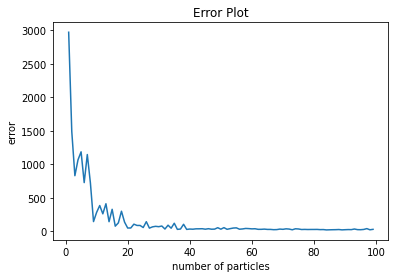

In [ ]:
plt.plot(list(range(1,100)),error_combined)
plt.xlabel('number of particles')
plt.ylabel('error')
plt.title('Error Plot')

**Observations**

1) As the number of particles increases the error between desired path and the estimated path decreases.\
2) The spikes in error in above plot is due to the random nature of SIR.\
3) At about 20 particles, the error is close to zero and any further addition o particles just increases the computational complexity.